In [2]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pl.seed_everything(0)

Global seed set to 0


0

In [4]:
# CHANGE TO POINT TO PATH ON YOUR COMPUTER!!!!
fn = "/storage/hunter_nisonoff/projects/activation_domain/data/OrthologTilingDFwActivities_20220131.csv"
df = pd.read_csv(fn)
df = df.loc[df.Activity != 0.0]
# average over duplicates
df = df.groupby("Seq").mean().reset_index()



df = pd.read_csv(fn)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]


seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
# get binary labels based on threshold
y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)
1

# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

train, val, test = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test

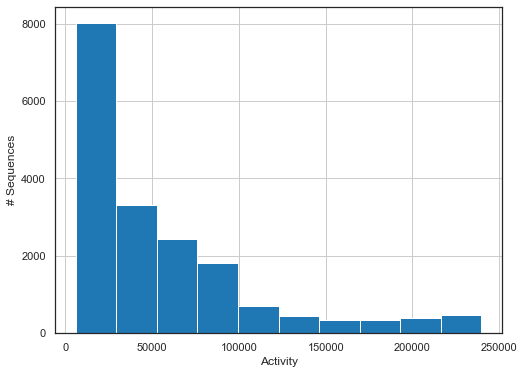

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
df.Activity.hist(ax=ax)
ax.set(xlabel="Activity")
ax.set(ylabel="# Sequences")
sns.set_context('poster')

In [6]:
# Create Training and Validation Datasets
pl.seed_everything(0)

bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)


Global seed set to 0


In [ ]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64


model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(gpus=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


/anaconda3/envs/activation_hunter/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/anaconda3/envs/activation_hunter/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /storage/hunter_nisonoff/projects/activation_domain/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0   

Sanity Checking DataLoader 0:   0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

/anaconda3/envs/activation_hunter/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.61it/s]val_rmse 1.4584070444107056
val_pearsonr 0.08345243334770203
val_spearmanr 0.09388377517461777
                                                                                                                                                                                             

/anaconda3/envs/activation_hunter/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 115/130 [00:02<00:00, 52.95it/s, loss=0.5, v_num=101]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:02<00:00, 56.88it/s, loss=0.5, v_num=101]val_rmse 0.711918830871582
val_pearsonr 0.7153893113136292
val_spearmanr 0.6552306413650513
Epoch 1:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 115/130 [00:04<00:00, 25.97it/s, loss=0.431, v_num=101]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 28.65it/s, loss=0.431, v_num=101]val_rmse 0.6900690793991089
val_pearsonr 0.7417632341384888
val_spearmanr 0.661419749259

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:06<00:00, 19.24it/s, loss=0.426, v_num=101]val_rmse 0.6914275884628296
val_pearsonr 0.7368180751800537
val_spearmanr 0.6636965274810791
Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 115/130 [00:08<00:01, 12.96it/s, loss=0.373, v_num=101]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:08<00:00, 14.47it/s, loss=0.373, v_num=101]val_rmse 0.674645721912384
val_pearsonr 0.7527329325675964
val_spearmanr 0.6879444122314453
Epoch 4:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 115/130 [00:11<00:01, 10.35it/s, loss=0.378, v_num=101]
Validation: 0it [00:00, ?i

Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:11<00:00, 11.59it/s, loss=0.378, v_num=101]val_rmse 0.6854459643363953
val_pearsonr 0.7490426301956177
val_spearmanr 0.6825174689292908
Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 115/130 [00:13<00:01,  8.63it/s, loss=0.37, v_num=101]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:13<00:00,  9.68it/s, loss=0.37, v_num=101]val_rmse 0.6786635518074036
val_pearsonr 0.7548851370811462
val_spearmanr 0.691049337387085
Epoch 6:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 115/130 [00:15<00:02,  7.41it/s, loss=0.371, v_num=101]
Validation: 0it [00:00, ?i

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:15<00:00,  8.32it/s, loss=0.371, v_num=101]val_rmse 0.666961669921875
val_pearsonr 0.7553852796554565
val_spearmanr 0.6959668397903442
Epoch 7:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 115/130 [00:17<00:02,  6.76it/s, loss=0.36, v_num=101]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:17<00:00,  7.60it/s, loss=0.36, v_num=101]val_rmse 0.6710802316665649
val_pearsonr 0.7519874572753906
val_spearmanr 0.6852651834487915
Epoch 8:  41%|████████████████████████████████████████████████▌                                                                      | 53/130 [00:17<00:25,  3.00it/s, loss=0.357, v_num=101]

In [ ]:
# get best model and save it
model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
torch.save(model.cpu().state_dict(), "adhunter.pt")

In [ ]:
# Load model 
model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter.pt"))
# put model on GPU, or ignore if you want to use CPU
model.cuda()

In [ ]:
test_ds = TensorDataset(X_test, y_cont_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model.eval()
X_test, y_test = test_ds[:]
y_test = y_test.reshape(-1)
with torch.no_grad():
    y_test_hat = model(X_test).reshape(-1)
    y_test_hat = y_test_hat.detach().numpy()
    y_test = y_test.numpy()

best_thresh = get_threshold(y_bin_test, y_test_hat)
best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(y_test_hat_unscaled, y_test_unscaled, alpha=0.5)
corr = spearmanr(y_test_hat_unscaled, y_test_unscaled).correlation
ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Spearman: {corr:.3f}")
ax.set(xlim=(-10000, 250_000), ylim=(-10000, 250_000))
plt.tight_layout()
plt.axvline(x=80_000, c='green', ymax=0.345)
plt.axhline(y=80_000, c='green', xmax=0.345)